c:\Users\Lenovo\Desktop\Retail_Store\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


✅ Data Loaded. Shape: (421570, 31)
Evaluating Model for: Store 1, Dept 92
📉 Preparing data for Store 1, Dept 92...
🧠 Training Prophet Model...


10:28:30 - cmdstanpy - INFO - Chain [1] start processing
10:28:30 - cmdstanpy - INFO - Chain [1] done processing


   Adding regressors: ['CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']
⏳ Running Cross-Validation (This may take a minute)...


  0%|          | 0/1 [00:00<?, ?it/s]10:28:30 - cmdstanpy - INFO - Chain [1] start processing
10:28:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


✅ Cross-Validation Complete. Tested 1 splits.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-05-04,132068.686999,109545.428738,153706.667843,140937.93,2012-04-29
1,2012-05-11,134616.627418,111296.012204,157163.289536,143194.31,2012-04-29
2,2012-05-18,137644.918653,114646.047840,160520.421328,139743.46,2012-04-29
3,2012-05-25,137757.989636,117101.000227,160103.709312,124556.59,2012-04-29
4,2012-06-01,135972.321126,111809.688159,158641.527031,134206.28,2012-04-29



Performance Metrics by Horizon:


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,7.612005e+07,8724.680793,8723.462791,0.061416,0.061416,0.063363,1.0
1,19 days,3.899026e+07,6244.217896,5338.111964,0.037460,0.037460,0.038441,1.0
2,26 days,8.934041e+07,9452.005823,7649.970492,0.060502,0.060502,0.057892,1.0
3,33 days,8.869793e+07,9417.957677,7483.720381,0.059573,0.059573,0.056863,1.0
4,40 days,1.643021e+08,12818.037195,9903.625501,0.065278,0.065278,0.068896,1.0


c:\Users\Lenovo\Desktop\Retail_Store\venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\Lenovo\Desktop\Retail_Store\venv\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


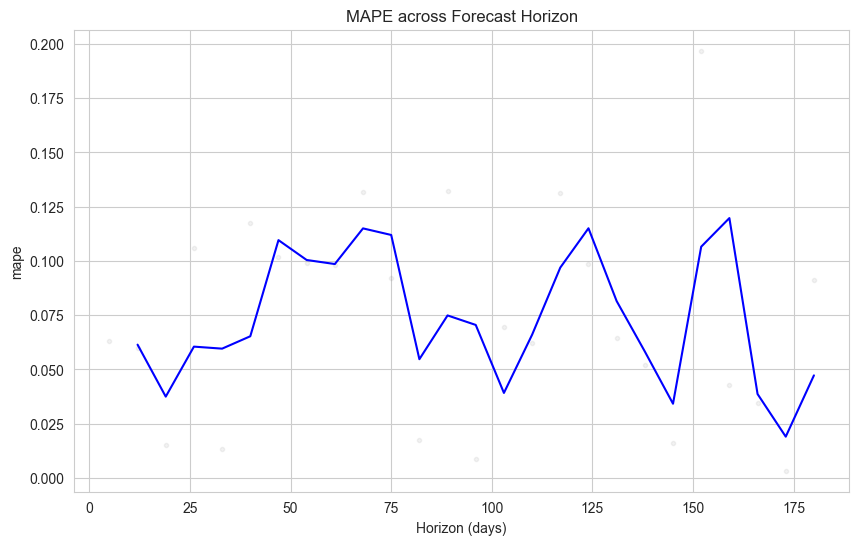

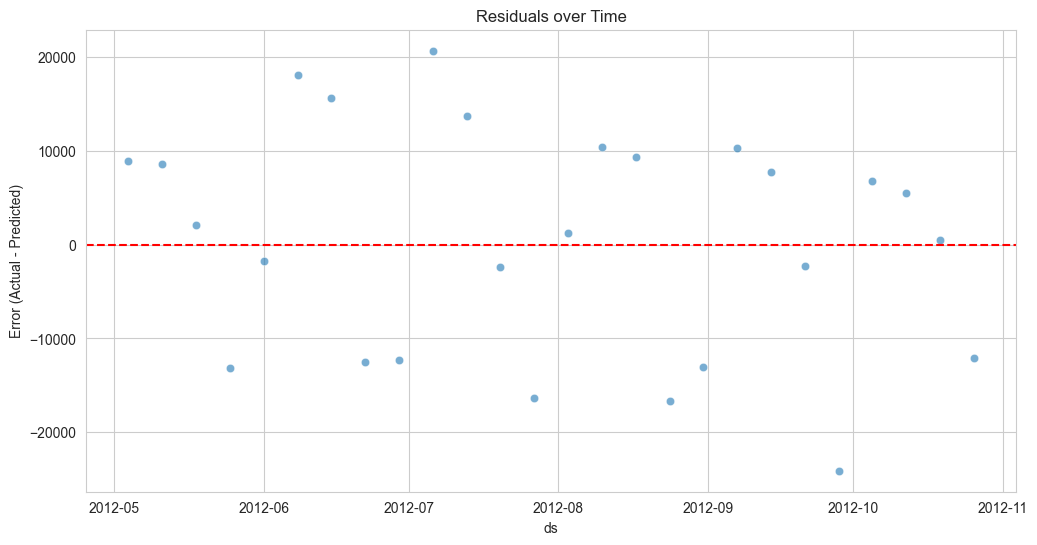

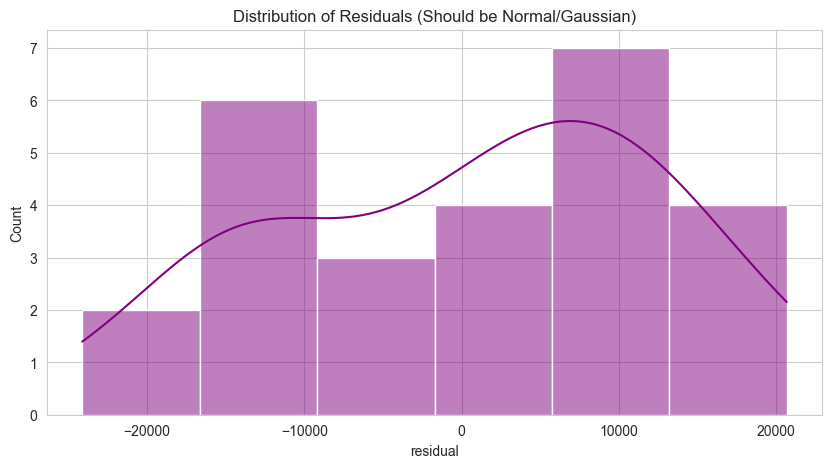

💰 Average Weekly Sales: $135,458.97
📉 Average Error (MAE): $10,224.64
⚠️ Error Percentage (MAPE): 7.37%

Business Impact:
On a typical week, our forecast is off by ±$10,225.
Inventory Safety Stock should cover at least this amount to prevent stockouts.


In [1]:
# %% [markdown]
# # 📊 Step 8: Advanced Model Evaluation
# **Project:** Integrated Retail Analytics
#
# **Objective:**
# To rigorously evaluate the forecasting model using **Cross-Validation** and **Residual Analysis**.
# We move beyond simple Train/Test splits to "Sliding Window" validation to ensure the model is robust across different time periods.
#
# **Key Metrics:**
# * **RMSE:** Penalty for large errors.
# * **MAE:** Average absolute error.
# * **MAPE:** Percentage error (Crucial for Retail - "We are off by X%").

# %% [markdown]
# ## 1. Setup & Data Loading

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import os
import sys

# Add src to path
sys.path.append(os.path.abspath('..'))
from src.forecasting import RetailForecaster

sns.set_style("whitegrid")

# Load Data
data_path = "../data/processed/model_ready_data.csv"
if not os.path.exists(data_path):
    print("❌ Error: Data not found.")
else:
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"✅ Data Loaded. Shape: {df.shape}")

# %% [markdown]
# ## 2. Initialize Model for Evaluation
# We'll use the same Store 1 / Top Dept example as before.

# %%
store_id = 1
top_dept = df[df['Store'] == 1].groupby('Dept')['Weekly_Sales'].sum().idxmax()

print(f"Evaluating Model for: Store {store_id}, Dept {top_dept}")

forecaster = RetailForecaster(df)
subset = forecaster.prepare_data(store_id, top_dept)

# Define Regressors
regressors = ['CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']

# Train on ALL data (Prophet CV handles the splitting internally)
model = forecaster.train_model(subset, regressors=regressors)

# %% [markdown]
# ## 3. Time-Series Cross-Validation
# Instead of one split, Prophet cuts the data into multiple training/testing chunks.
# * **Initial:** Training data size (e.g., 730 days / 2 years).
# * **Period:** How often to make a prediction (e.g., every 90 days).
# * **Horizon:** How far into the future to predict (e.g., 180 days).

# %%
print("⏳ Running Cross-Validation (This may take a minute)...")
df_cv = cross_validation(
    model, 
    initial='730 days', 
    period='90 days', 
    horizon='180 days'
)

print(f"\n✅ Cross-Validation Complete. Tested {len(df_cv['cutoff'].unique())} splits.")
display(df_cv.head())

# %% [markdown]
# ## 4. Performance Metrics (MAPE & RMSE)
# We calculate metrics for different forecast horizons.

# %%
df_p = performance_metrics(df_cv)
print("\nPerformance Metrics by Horizon:")
display(df_p.head())

# Visualize MAPE (Percentage Error)
# Lower is better. A MAPE of 0.10 means 10% error.
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('MAPE across Forecast Horizon')
plt.show()

# %% [markdown]
# ## 5. Residual Analysis
# Are our errors random (Good) or is there a pattern (Bad)?
# * **Residual = Actual - Predicted**
# * We want residuals to be centered around 0 with no clear trend.

# %%
# Calculate Residuals
df_cv['residual'] = df_cv['y'] - df_cv['yhat']

plt.figure(figsize=(12, 6))
sns.scatterplot(x='ds', y='residual', data=df_cv, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals over Time')
plt.ylabel('Error (Actual - Predicted)')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 5))
sns.histplot(df_cv['residual'], kde=True, color='purple')
plt.title('Distribution of Residuals (Should be Normal/Gaussian)')
plt.show()

# %% [markdown]
# **Interpretation:**
# * If the histogram is Bell-shaped centered at 0, the model is unbiased.
# * If there are massive outliers, check if those dates correspond to unflagged events (e.g., hurricanes, local events).

# %% [markdown]
# ## 6. Business Interpretation
# Translate metrics into money.

# %%
avg_sales = subset['y'].mean()
avg_mape = df_p['mape'].mean()
avg_mae = df_p['mae'].mean()

print(f"💰 Average Weekly Sales: ${avg_sales:,.2f}")
print(f"📉 Average Error (MAE): ${avg_mae:,.2f}")
print(f"⚠️ Error Percentage (MAPE): {avg_mape*100:.2f}%")

print("\nBusiness Impact:")
print(f"On a typical week, our forecast is off by ±${avg_mae:,.0f}.")
print("Inventory Safety Stock should cover at least this amount to prevent stockouts.")